In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pydicom
import cv2
import seaborn as sns
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.16.2


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Step 1: Import the data. [ 3 points ]

In [4]:
train_images_path = os.path.join( "stage_2_train_images")
test_images_path = os.path.join("stage_2_test_images")
train_labels_path = os.path.join("stage_2_train_labels.csv")
sample_submission_path = os.path.join("stage_2_sample_submission.csv")
class_info_path = os.path.join( "stage_2_detailed_class_info.csv")

In [5]:
train_labels = pd.read_csv('stage_2_train_labels.csv')
sample_submission = pd.read_csv('stage_2_sample_submission.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

In [6]:
# Display basic information
print("Training Labels:")
print(train_labels.head())
print(f"Number of training images: {len(os.listdir(train_images_path))}")

print("\nClass Info:")
print(class_info.head())

print("\nSample Submission:")
print(sample_submission.head())

print(f"Number of test images: {len(os.listdir(test_images_path))}")

Training Labels:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
Number of training images: 26684

Class Info:
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

Sample Submission:
                              patie

Step 2: Map training and testing images to its classes. [ 4 points ]

In [7]:
train_labels_with_classes = train_labels.merge(class_info, on='patientId', how='left')
train_labels_with_classes.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [8]:
# Group data by class type
class_mapping = train_labels_with_classes.groupby('class')['patientId'].apply(list).to_dict()

print("Class Mapping:")
for class_type, patient_ids in class_mapping.items():
    print(f"{class_type}: {len(patient_ids)} images")

Class Mapping:
Lung Opacity: 16957 images
No Lung Opacity / Not Normal: 11821 images
Normal: 8851 images


Step 3: Map training and testing images to its annotations. [ 4 points ]

In [9]:
annotations = defaultdict(list)

for _, row in train_labels.iterrows():
    patient_id = row['patientId']
    if not pd.isna(row['x']):  # Only add bounding boxes for labeled images
        annotations[patient_id].append({
            'x': row['x'],
            'y': row['y'],
            'width': row['width'],
            'height': row['height'],
            'target': row['Target']
        })

print("\nAnnotations for first 5 patientIds:")
for i, (patient_id, boxes) in enumerate(annotations.items()):
    if i >= 5:
        break
    print(f"{patient_id}: {boxes}")


Annotations for first 5 patientIds:
00436515-870c-4b36-a041-de91049b9ab4: [{'x': 264.0, 'y': 152.0, 'width': 213.0, 'height': 379.0, 'target': 1}, {'x': 562.0, 'y': 152.0, 'width': 256.0, 'height': 453.0, 'target': 1}]
00704310-78a8-4b38-8475-49f4573b2dbb: [{'x': 323.0, 'y': 577.0, 'width': 160.0, 'height': 104.0, 'target': 1}, {'x': 695.0, 'y': 575.0, 'width': 162.0, 'height': 137.0, 'target': 1}]
00aecb01-a116-45a2-956c-08d2fa55433f: [{'x': 288.0, 'y': 322.0, 'width': 94.0, 'height': 135.0, 'target': 1}, {'x': 547.0, 'y': 299.0, 'width': 119.0, 'height': 165.0, 'target': 1}]
00c0b293-48e7-4e16-ac76-9269ba535a62: [{'x': 306.0, 'y': 544.0, 'width': 168.0, 'height': 244.0, 'target': 1}, {'x': 650.0, 'y': 511.0, 'width': 206.0, 'height': 284.0, 'target': 1}]
00f08de1-517e-4652-a04f-d1dc9ee48593: [{'x': 181.0, 'y': 184.0, 'width': 206.0, 'height': 506.0, 'target': 1}, {'x': 571.0, 'y': 275.0, 'width': 230.0, 'height': 476.0, 'target': 1}]


Step 4: Preprocessing and Visualisation of different classes [4 Points]

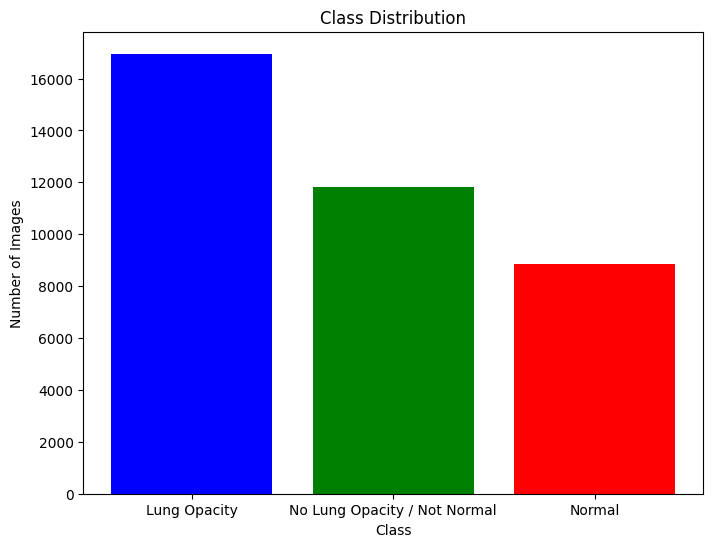

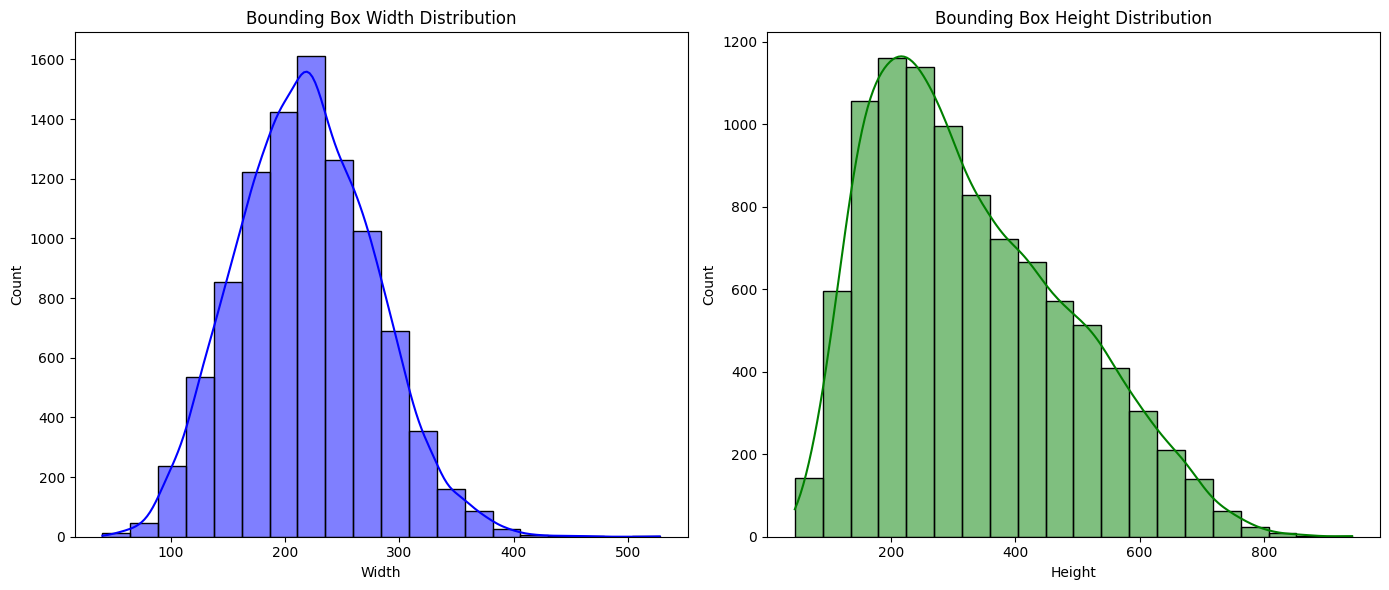

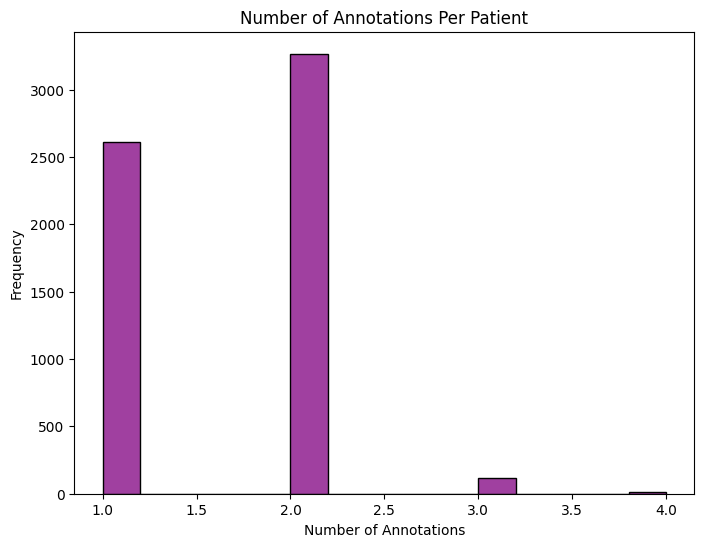

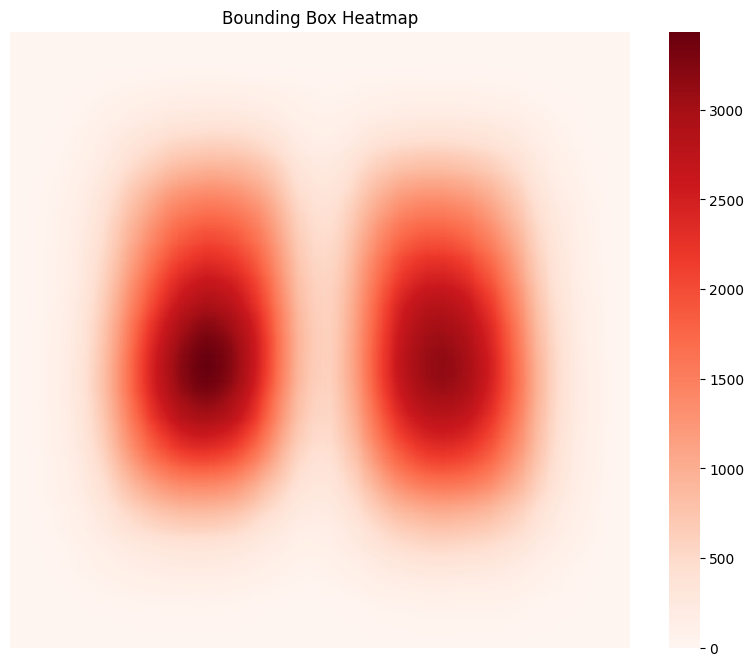

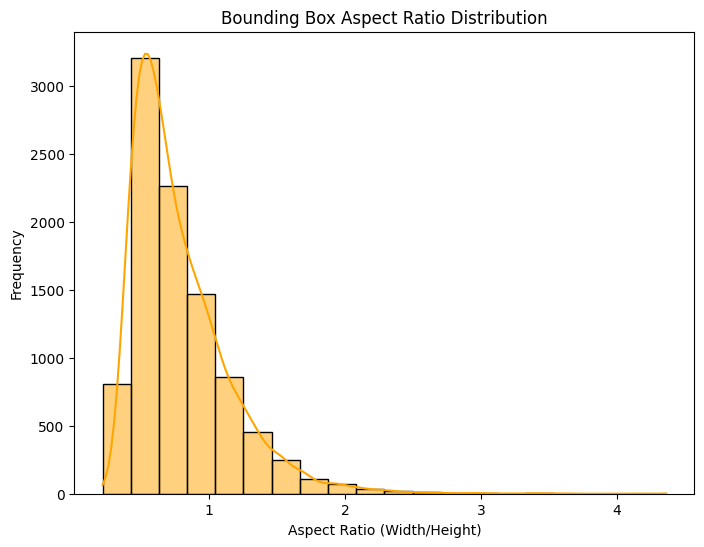

In [10]:
# Function to load a DICOM file and return its pixel array
def load_dicom_image(patient_id, folder_path):
    file_path = os.path.join(folder_path, f"{patient_id}.dcm")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    dicom_data = pydicom.dcmread(file_path)
    return dicom_data.pixel_array

# Class distribution bar plot
def visualize_class_distribution(class_mapping):
    class_names = list(class_mapping.keys())
    class_counts = [len(patient_ids) for patient_ids in class_mapping.values()]
    
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_counts, color=['blue', 'green', 'red'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution")
    plt.show()

def visualize_bounding_box_distribution(annotations):
    widths = []
    heights = []
    for boxes in annotations.values():
        for box in boxes:
            widths.append(box['width'])
            heights.append(box['height'])
    
    # Plot distributions
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(widths, kde=True, bins=20, color="blue")
    plt.title("Bounding Box Width Distribution")
    plt.xlabel("Width")
    
    plt.subplot(1, 2, 2)
    sns.histplot(heights, kde=True, bins=20, color="green")
    plt.title("Bounding Box Height Distribution")
    plt.xlabel("Height")
    
    plt.tight_layout()
    plt.show()

def visualize_annotations_per_patient(annotations):
    annotation_counts = [len(boxes) for boxes in annotations.values()]
    
    plt.figure(figsize=(8, 6))
    sns.histplot(annotation_counts, kde=False, bins=15, color="purple")
    plt.title("Number of Annotations Per Patient")
    plt.xlabel("Number of Annotations")
    plt.ylabel("Frequency")
    plt.show()

def visualize_bounding_box_heatmap(annotations, image_shape=(1024, 1024)):
    heatmap = np.zeros(image_shape, dtype=np.int32)
    
    for boxes in annotations.values():
        for box in boxes:
            x, y, width, height = int(box['x']), int(box['y']), int(box['width']), int(box['height'])
            heatmap[y:y+height, x:x+width] += 1
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap, cmap="Reds")
    plt.title("Bounding Box Heatmap")
    plt.axis("off")
    plt.show()

def visualize_aspect_ratio(annotations):
    aspect_ratios = []
    for boxes in annotations.values():
        for box in boxes:
            aspect_ratios.append(box['width'] / box['height'])
    
    plt.figure(figsize=(8, 6))
    sns.histplot(aspect_ratios, kde=True, bins=20, color="orange")
    plt.title("Bounding Box Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (Width/Height)")
    plt.ylabel("Frequency")
    plt.show()


visualize_class_distribution(class_mapping)
visualize_bounding_box_distribution(annotations)
visualize_annotations_per_patient(annotations)
visualize_bounding_box_heatmap(annotations)
visualize_aspect_ratio(annotations)

Step 5: Display images with bounding box. [ 5 points ]


Class: Lung Opacity


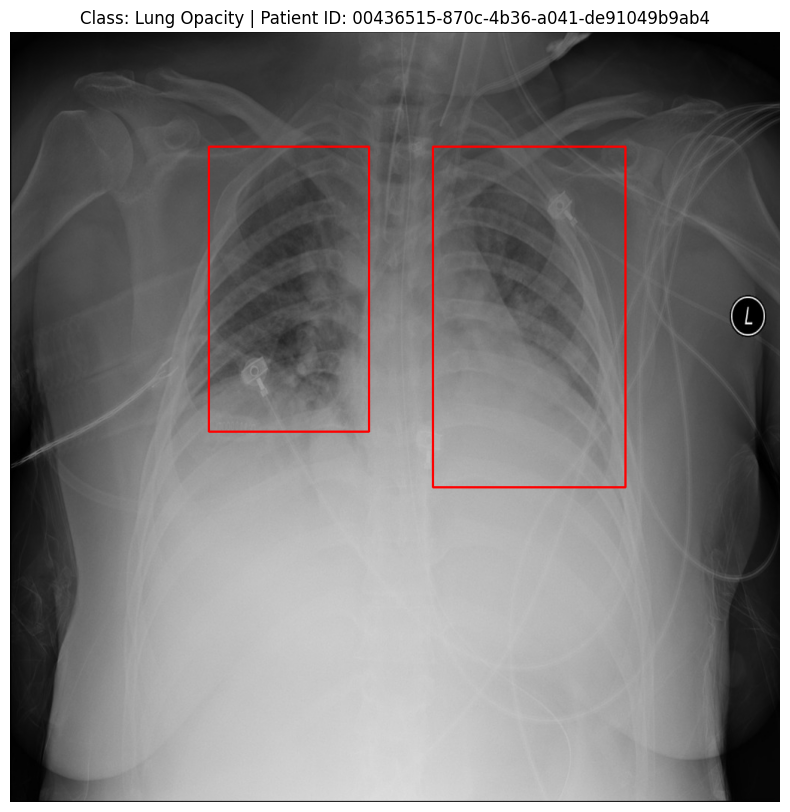

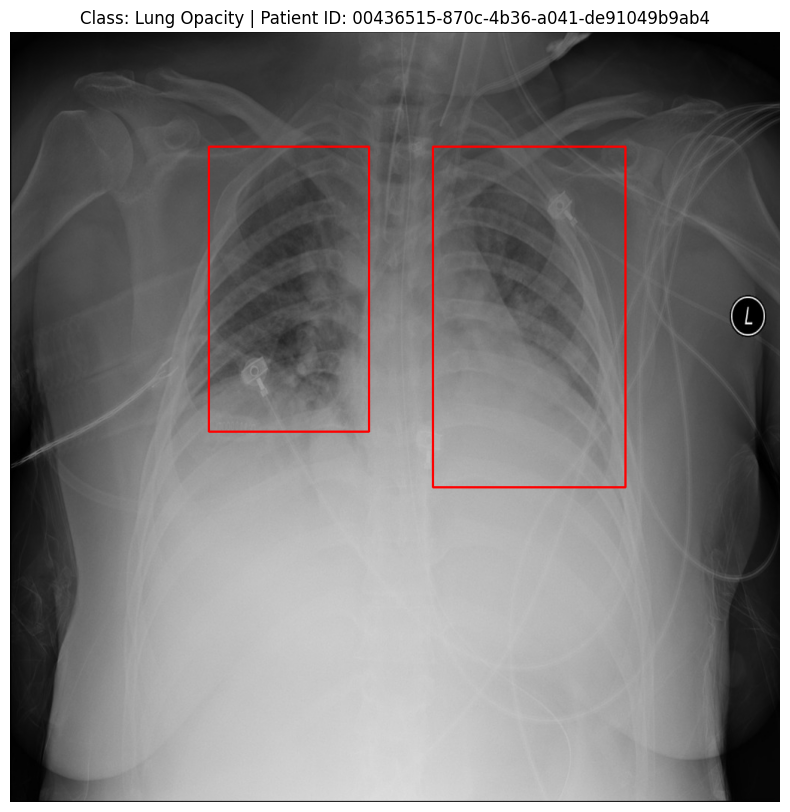

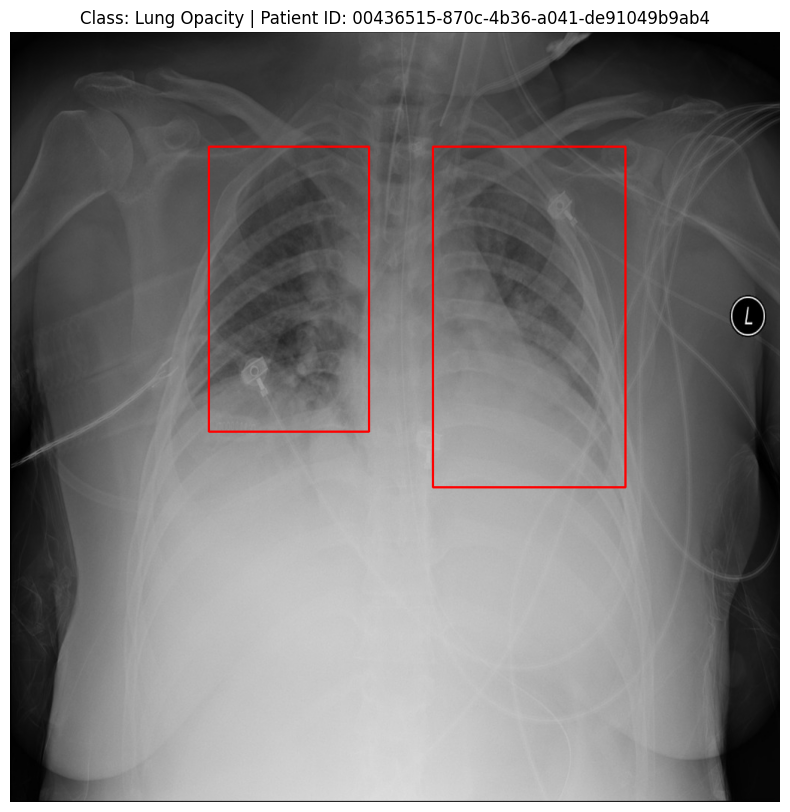


Class: No Lung Opacity / Not Normal


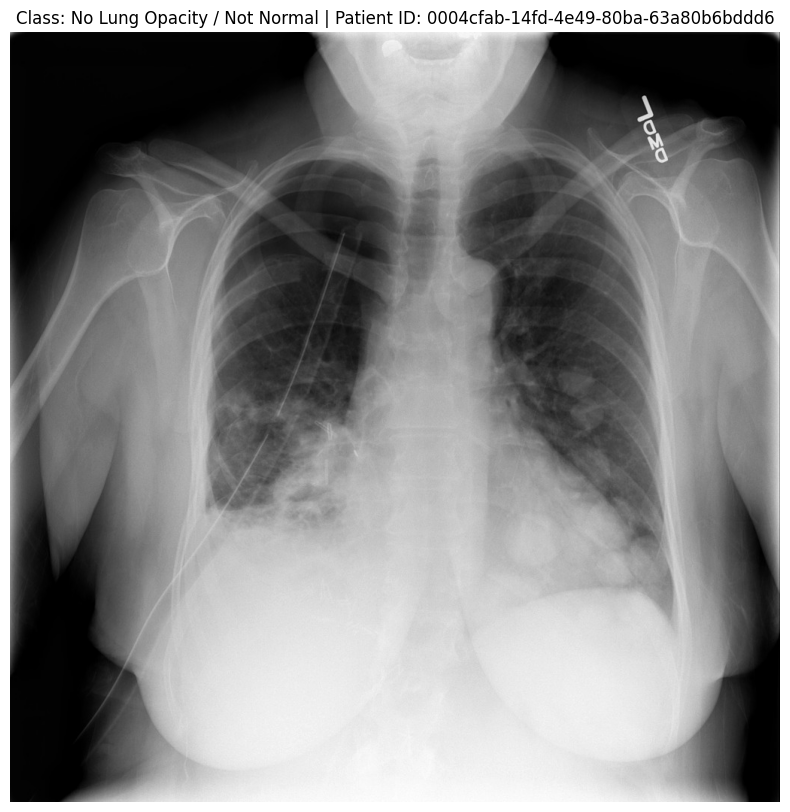

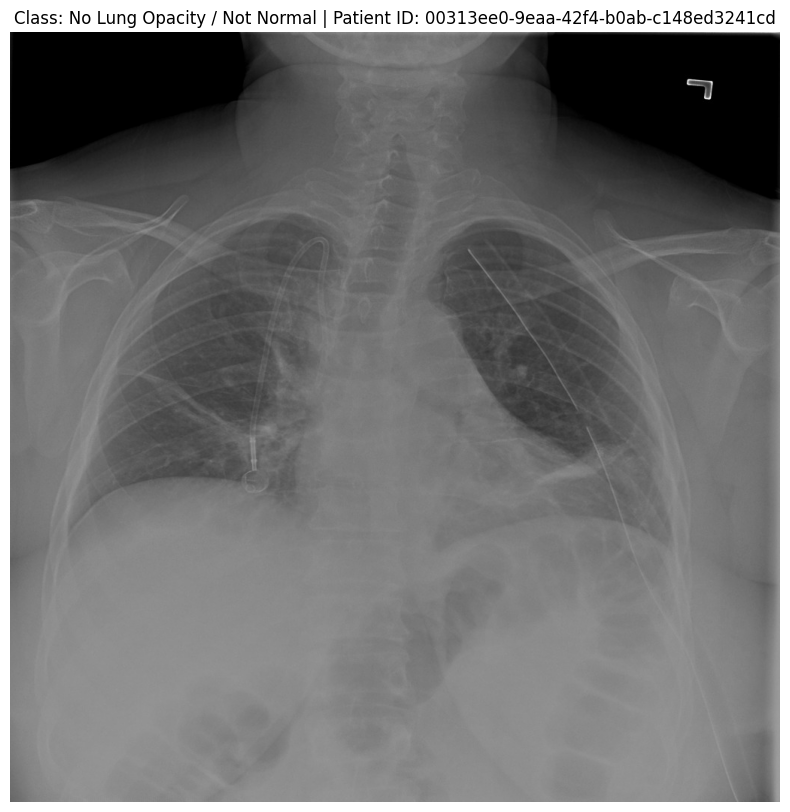

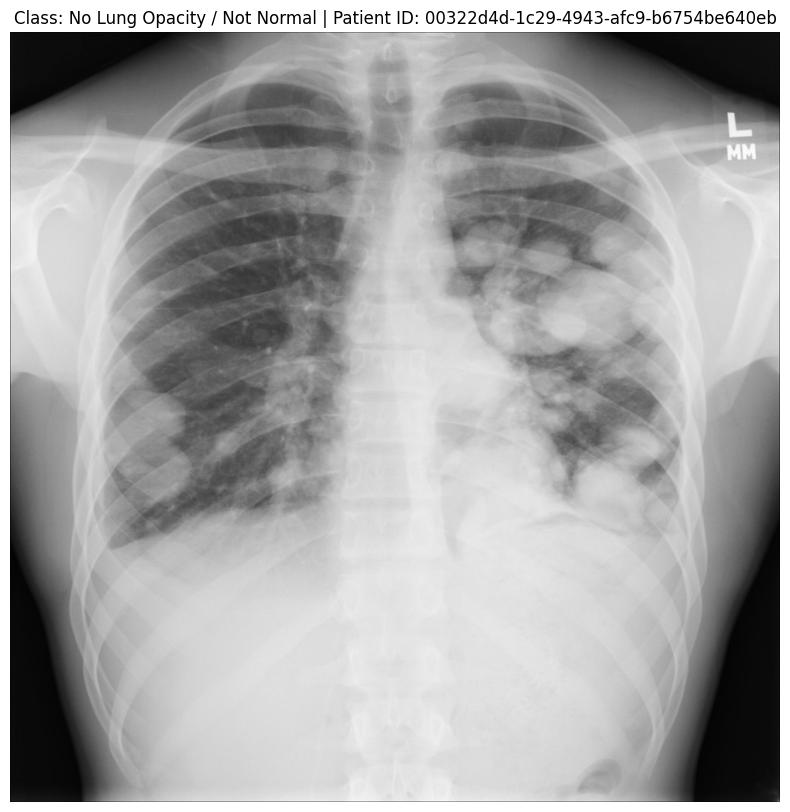


Class: Normal


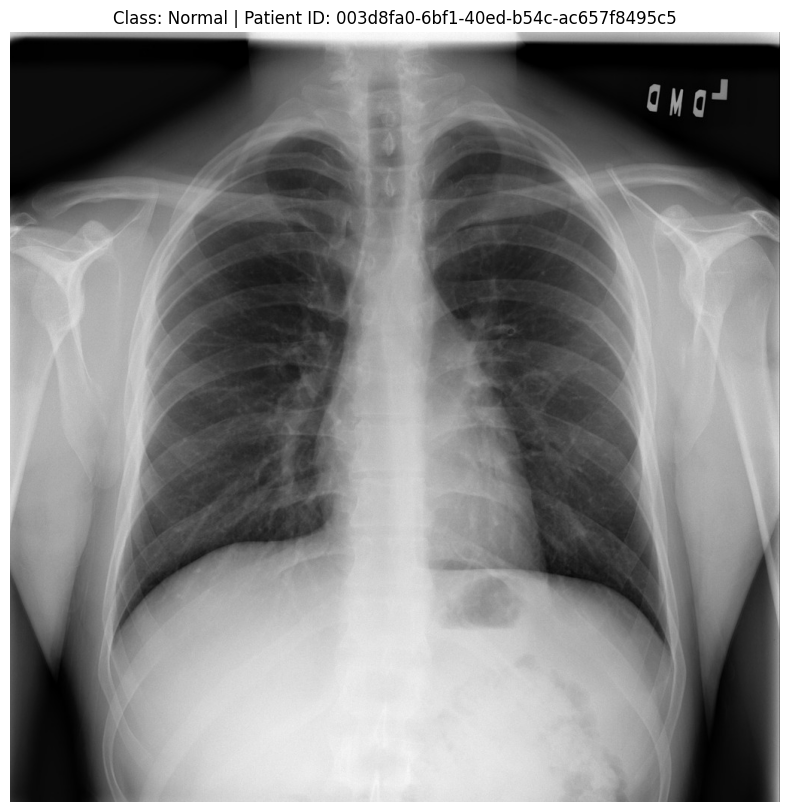

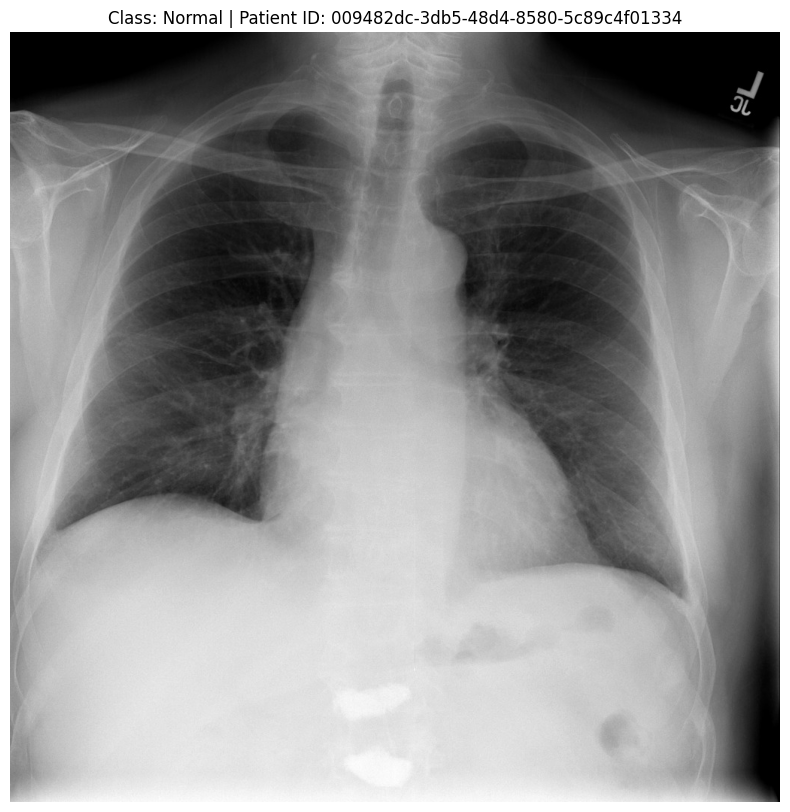

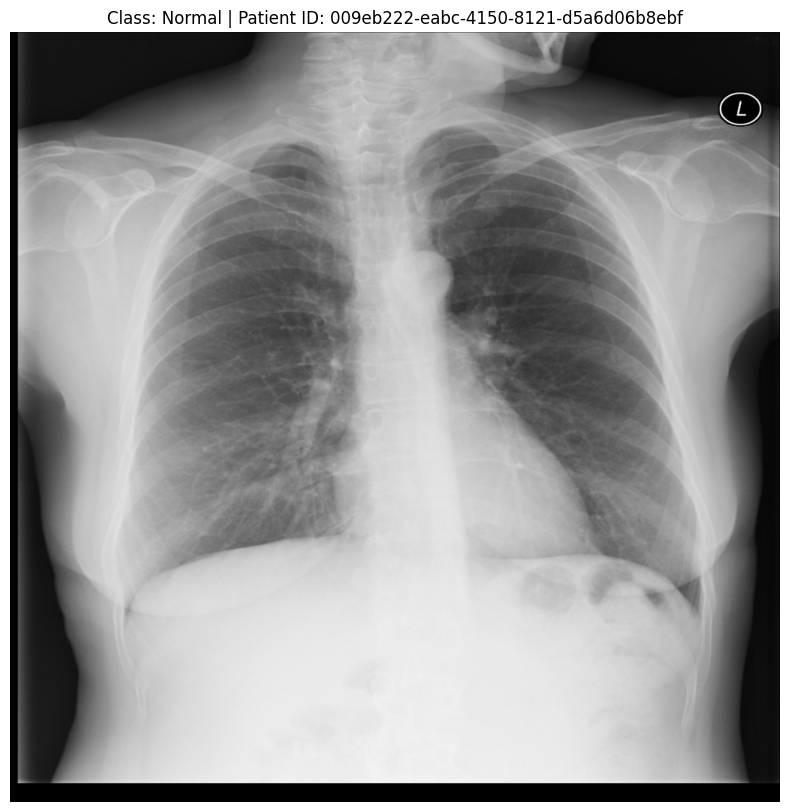

In [11]:
# Function to display a DICOM image with bounding boxes
def display_image_with_boxes(patient_id, folder_path, annotations, title=""):
    image = load_dicom_image(patient_id, folder_path)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  # Normalize for display
    
    # Convert to RGB for matplotlib compatibility
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Draw bounding boxes if present
    if patient_id in annotations:
        for box in annotations[patient_id]:
            x, y, width, height = int(box['x']), int(box['y']), int(box['width']), int(box['height'])
            color = (255, 0, 0) if box['target'] == 1 else (0, 255, 0)  # Red for pneumonia, green otherwise
            cv2.rectangle(image_rgb, (x, y), (x + width, y + height), color, 2)
    
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Display a few examples from each class
for class_type, patient_ids in class_mapping.items():
    print(f"\nClass: {class_type}")
    for i, patient_id in enumerate(patient_ids[:3]):  # Display 3 images per class
        title = f"Class: {class_type} | Patient ID: {patient_id}"
        display_image_with_boxes(patient_id, train_images_path, annotations, title=title)

## ***We are getting the same image for lung opacity class, need to check*** ##


Class: No Lung Opacity / Not Normal


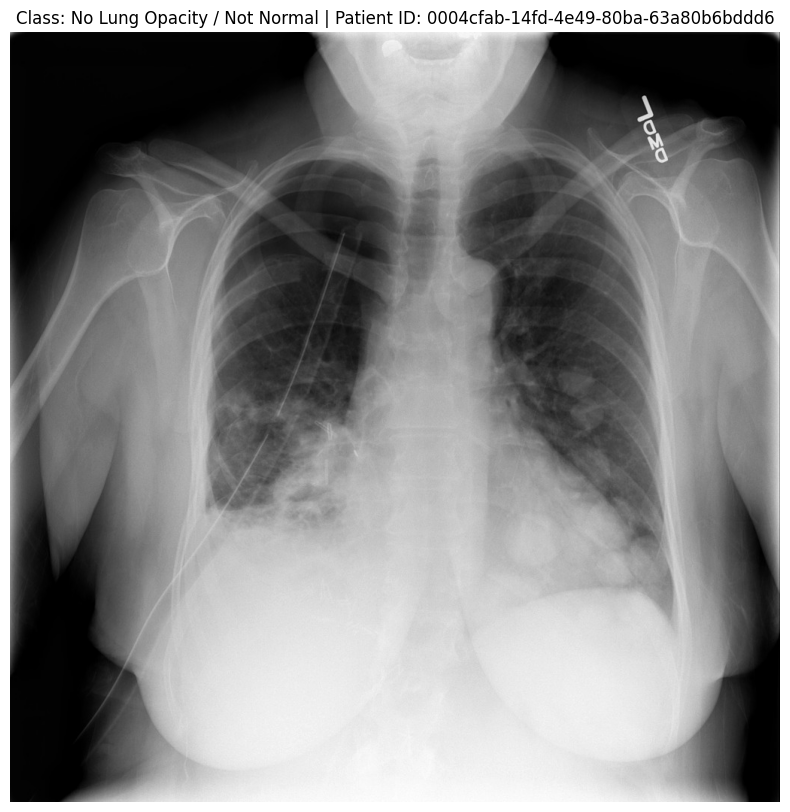

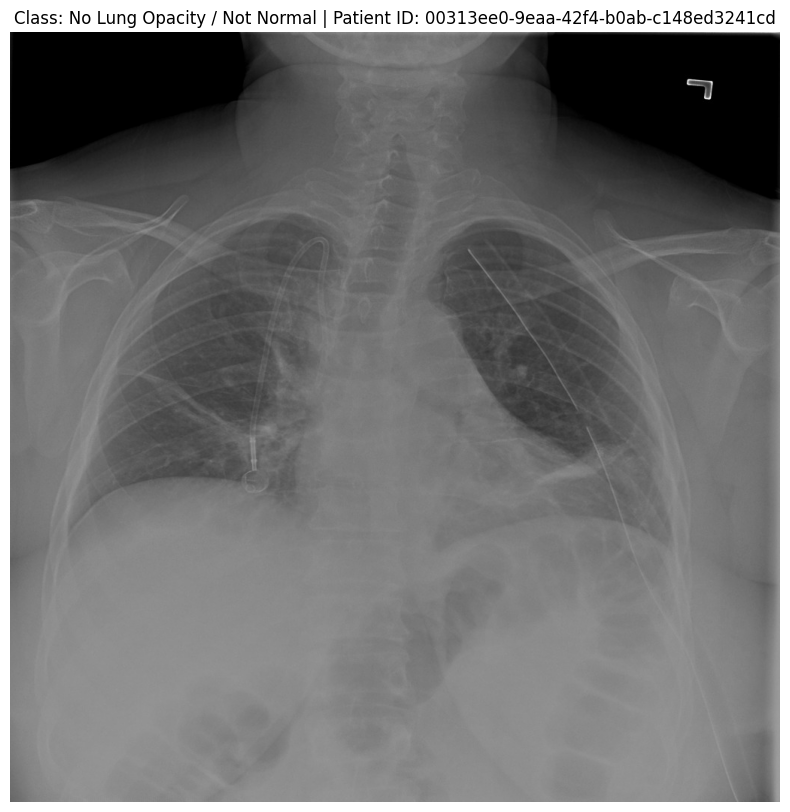

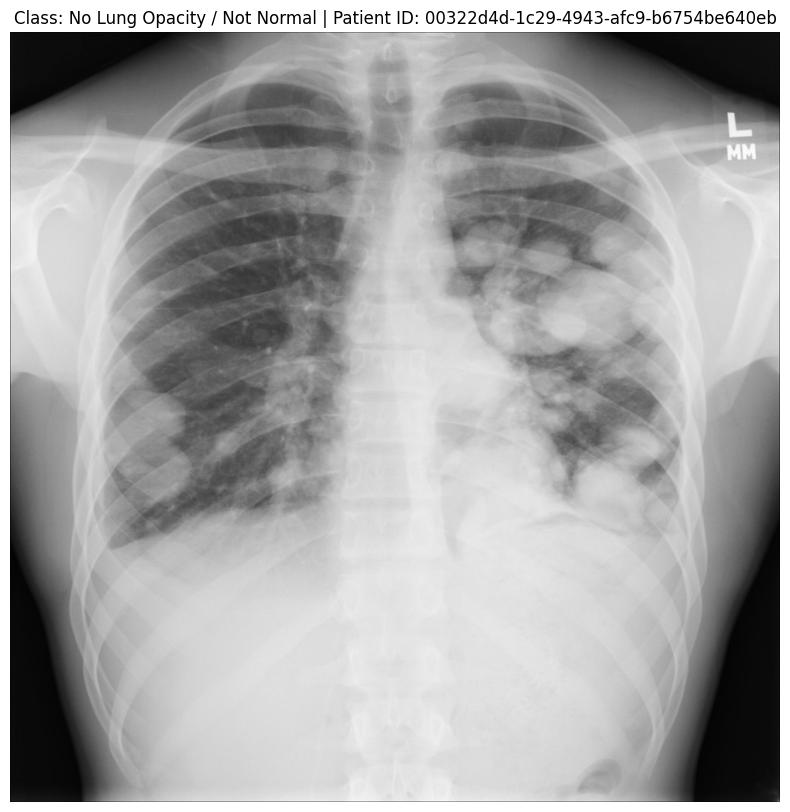


Class: Normal


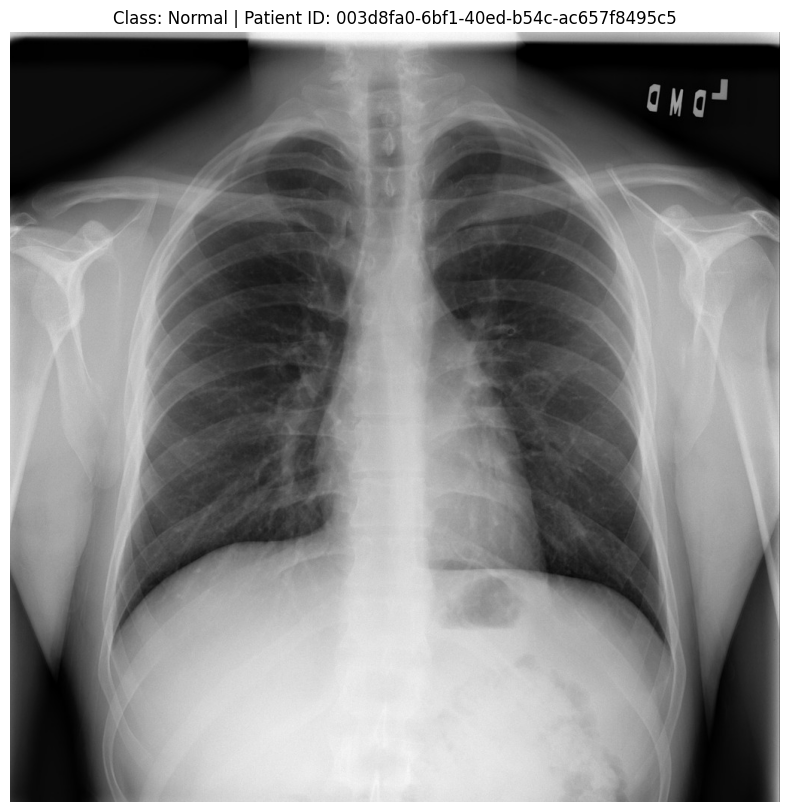

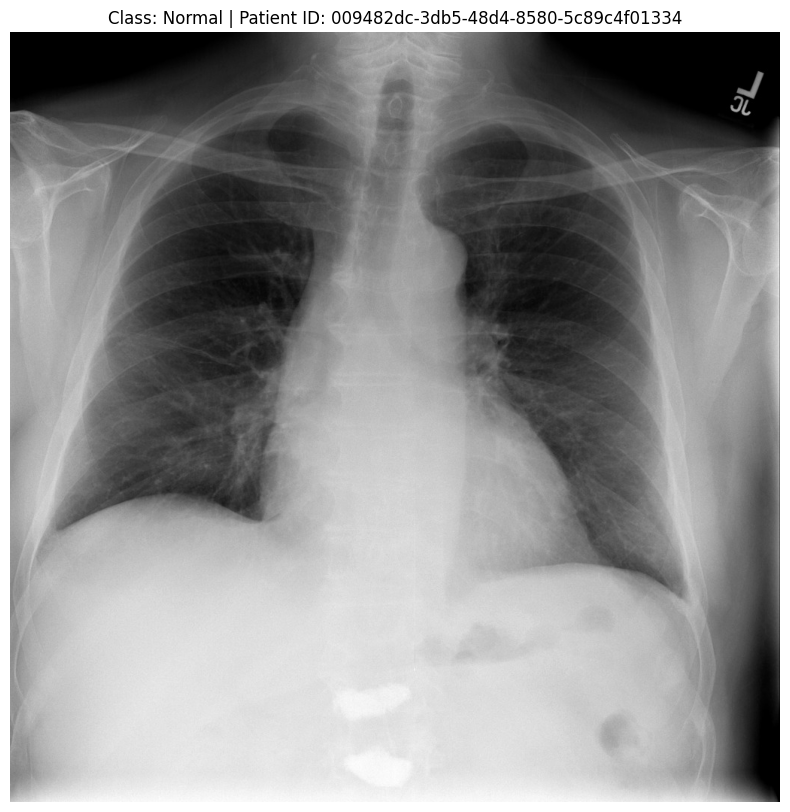

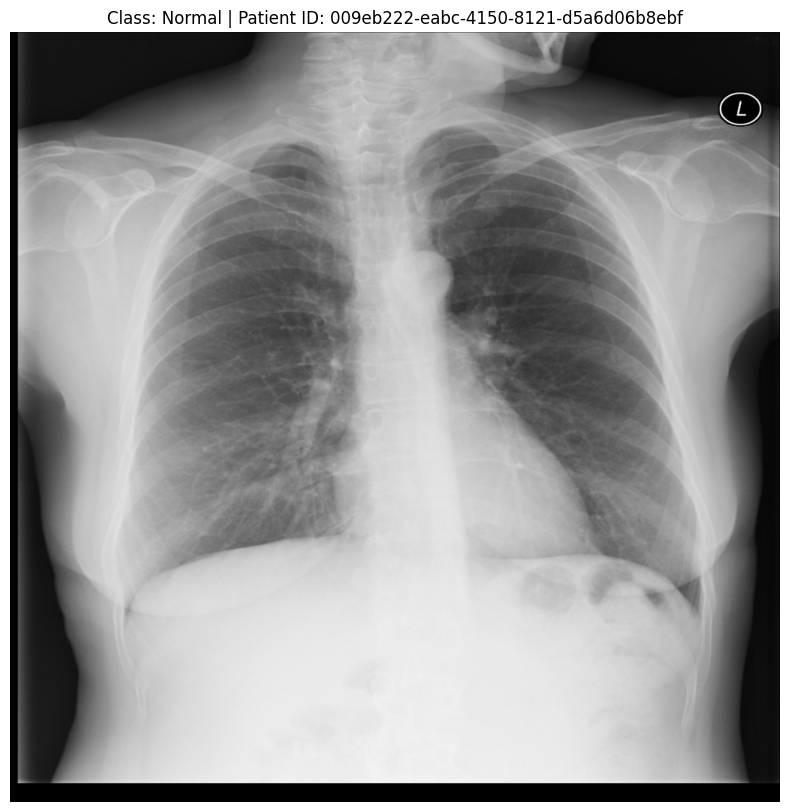

In [12]:
def visualize_non_pneumonia_images(class_mapping, folder_path):
    no_pneumonia_classes = ["No Lung Opacity / Not Normal", "Normal"]
    for class_type in no_pneumonia_classes:
        if class_type in class_mapping:
            print(f"\nClass: {class_type}")
            for i, patient_id in enumerate(class_mapping[class_type][:3]):  # Show 3 examples
                title = f"Class: {class_type} | Patient ID: {patient_id}"
                display_image_with_boxes(patient_id, folder_path, annotations, title=title)

visualize_non_pneumonia_images(class_mapping, train_images_path)

Step 6: Design, train and test basic CNN models for classification. [ 10 points ]

In [13]:
def preprocess_data():
    """
    Preprocess images and labels for CNN training.
    
    Returns:
        X_train, X_test, y_train, y_test: Processed datasets.
    """
    images = []
    labels = []

    for _, row in train_labels.iterrows():
        patient_id = row['patientId']
        dcm_file_path = f"{train_images_path}/{patient_id}.dcm"
        dicom = pydicom.dcmread(dcm_file_path)
        image = dicom.pixel_array

        # Add a channel dimension to the image
        image = np.expand_dims(image, axis=-1)

        # Resize images to a fixed size (e.g., 128x128)
        image_resized = tf.image.resize(image, (128, 128)).numpy()

        images.append(image_resized)
        labels.append(row['Target'])

    images = np.array(images)  # Shape: (num_samples, 128, 128, 1)
    labels = np.array(labels)

    # Split the data
    return train_test_split(images, labels, test_size=0.2, random_state=42)



In [14]:
# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data()

2024-12-22 22:10:36.865205: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-22 22:10:36.865225: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-22 22:10:36.865242: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-22 22:10:36.865259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-22 22:10:36.865269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:

# Define a basic CNN model
def build_cnn_model():
    """
    Build a basic CNN model for classification.
    
    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Build and train the model
cnn_model = build_cnn_model()
cnn_model.summary() #print the model summary


/opt/anaconda3/envs/macos-tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/10


2024-12-22 22:13:10.655224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


756/756 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.6420 - loss: 57.1012 - val_accuracy: 0.6841 - val_loss: 0.6216
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6873 - loss: 0.6050 - val_accuracy: 0.6857 - val_loss: 0.6032
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6913 - loss: 0.6104 - val_accuracy: 0.6866 - val_loss: 0.6028
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6762 - loss: 0.6799 - val_accuracy: 0.6925 - val_loss: 0.5981
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6688 - loss: 0.7905 - val_accuracy: 0.6886 - val_loss: 0.6058
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6685 - loss: 0.8971 - val_accuracy: 0.6937 - val_loss: 0.6231
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6708 - loss: 1.0099 - val_accuracy: 0.6973 - val_loss: 0.6771
Epoch 8/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6645 - loss: 1.1221 - val_accura

In [17]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    Flatten, Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [18]:
def build_cnn_model_v1():
    """
    CNN model with batch normalization and smaller filters.
    
    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model_v1 = build_cnn_model_v1() 
cnn_model_v1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,769 (28.20 MB)

 Trainable params: 7,392,321 (28.20 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
cnn_model_v1_history = cnn_model_v1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.7000 - loss: 0.6829 - val_accuracy: 0.7724 - val_loss: 0.4815
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.7604 - loss: 0.4893 - val_accuracy: 0.7570 - val_loss: 0.4900
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.7721 - loss: 0.4751 - val_accuracy: 0.7413 - val_loss: 0.4915
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.7728 - loss: 0.4757 - val_accuracy: 0.7714 - val_loss: 0.5036
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.7790 - loss: 0.4645 - val_accuracy: 0.7775 - val_loss: 0.4716
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.7874 - loss: 0.4532 - val_accuracy: 0.7302 - val_loss: 0.5286
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.7931 - loss: 0.4510 - val_accuracy: 0.7742 - val_loss: 0.4808
Epoch 8/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.7956 - loss: 0.4407 - 

In [20]:
# Get training and validation accuracy from history
cnn_model_v1_train_accuracy = cnn_model_v1_history.history['accuracy'][-1]  # Accuracy of the last epoch on training data
cnn_model_v1_val_accuracy = cnn_model_v1_history.history['val_accuracy'][-1]  # Accuracy of the last epoch on validation data

print(f"Final Training Accuracy: {cnn_model_v1_train_accuracy:.2f}")
print(f"Final Validation Accuracy: {cnn_model_v1_val_accuracy:.2f}")

# Evaluate the model on the test data
cnn_model_v1_test_loss, cnn_model_v1_test_accuracy = cnn_model_v1.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {cnn_model_v1_test_accuracy:.2f}")

Final Training Accuracy: 0.81
Final Validation Accuracy: 0.69
Test Accuracy: 0.69


In [21]:
def build_cnn_model_v2():
    """
    CNN model with depthwise separable convolutions.
    
    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        SeparableConv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# Augment data during training
train_generator = datagen.flow(X_train, y_train, batch_size=32)



In [23]:
# Adjust model to train with augmented data
cnn_model_v2 = build_cnn_model_v2()
cnn_model_v2.summary()

/opt/anaconda3/envs/macos-tensorflow/lib/python3.10/site-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 126, 126, 32)   │            73 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 61, 61, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 28, 28, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,614,250 (6.16 MB)

 Trainable params: 1,613,674 (6.16 MB)

 Non-trainable params: 576 (2.25 KB)

In [24]:
build_cnn_model_v2_history=cnn_model_v2.fit(train_generator, epochs=10, validation_data=(X_test, y_test))


# Get training and validation accuracy from history
cnn_model_v2_train_accuracy = build_cnn_model_v2_history.history['accuracy'][-1]  # Accuracy of the last epoch on training data
cnn_model_v2_val_accuracy = build_cnn_model_v2_history.history['val_accuracy'][-1]  # Accuracy of the last epoch on validation data

print(f"Final Training Accuracy: {cnn_model_v2_train_accuracy:.2f}")
print(f"Final Validation Accuracy: {cnn_model_v2_val_accuracy:.2f}")

Epoch 1/10


/opt/anaconda3/envs/macos-tensorflow/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


756/756 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.6752 - loss: 0.7355 - val_accuracy: 0.7557 - val_loss: 0.5222
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.7439 - loss: 0.5233 - val_accuracy: 0.7494 - val_loss: 0.5121
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.7584 - loss: 0.4997 - val_accuracy: 0.7635 - val_loss: 0.4843
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.7612 - loss: 0.4962 - val_accuracy: 0.7663 - val_loss: 0.4803
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.7618 - loss: 0.4948 - val_accuracy: 0.7476 - val_loss: 0.5039
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.7691 - loss: 0.4840 - val_accuracy: 0.7674 - val_loss: 0.4758
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.7713 - loss: 0.4829 - val_accuracy: 0.7127 - val_loss: 0.6231
Epoch 8/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - accuracy: 0.7684 - loss: 0.4885 - val_accurac

In [25]:
# Evaluate the model on the test data
cnn_model_v2_test_loss, cnn_model_v2_test_accuracy = cnn_model_v2.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {cnn_model_v2_test_accuracy:.2f}")

Test Accuracy: 0.73


In [26]:
from tensorflow.keras.optimizers import SGD

def build_cnn_model_sgd():
    """
    CNN model with SGD optimizer.
    
    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        SeparableConv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
cnn_model_sgd = build_cnn_model_sgd()
cnn_model_sgd.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_3              │ (None, 126, 126, 32)   │            73 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 61, 61, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 28, 28, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,614,250 (6.16 MB)

 Trainable params: 1,613,674 (6.16 MB)

 Non-trainable params: 576 (2.25 KB)

In [27]:
cnn_model_sgd_history=cnn_model_sgd.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.7062 - loss: 0.6132 - val_accuracy: 0.7653 - val_loss: 0.4983
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.7548 - loss: 0.5098 - val_accuracy: 0.7612 - val_loss: 0.4999
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.7570 - loss: 0.5029 - val_accuracy: 0.7630 - val_loss: 0.4914
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7603 - loss: 0.5000 - val_accuracy: 0.7421 - val_loss: 0.5221
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7645 - loss: 0.4993 - val_accuracy: 0.7681 - val_loss: 0.4904
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.7630 - loss: 0.4919 - val_accuracy: 0.7756 - val_loss: 0.4714
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.7694 - loss: 0.4822 - val_accuracy: 0.7631 - val_loss: 0.4875
Epoch 8/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.7656 - loss: 0.4840 - 

In [28]:
# Get training and validation accuracy from history
cnn_model_sgd_train_accuracy = cnn_model_sgd_history.history['accuracy'][-1]  # Accuracy of the last epoch on training data
cnn_model_sgd_val_accuracy = cnn_model_sgd_history.history['val_accuracy'][-1]  # Accuracy of the last epoch on validation data

print(f"Final Training Accuracy: {cnn_model_sgd_train_accuracy:.2f}")
print(f"Final Validation Accuracy: {cnn_model_sgd_val_accuracy:.2f}")

# Evaluate the model on the test data
cnn_model_sgd_test_loss, cnn_model_sgd_test_accuracy = cnn_model_sgd.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {cnn_model_sgd_test_accuracy:.2f}")

Final Training Accuracy: 0.78
Final Validation Accuracy: 0.73
Test Accuracy: 0.73


In [29]:
from tensorflow.keras.optimizers import RMSprop

def build_cnn_model_rmsprop():
    """
    CNN model with RMSprop optimizer.
    
    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        SeparableConv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
cnn_model_rmsprop = build_cnn_model_rmsprop()
cnn_model_rmsprop.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_6              │ (None, 126, 126, 32)   │            73 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 61, 61, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_8              │ (None, 28, 28, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,614,250 (6.16 MB)

 Trainable params: 1,613,674 (6.16 MB)

 Non-trainable params: 576 (2.25 KB)

In [30]:
cnn_model_rmsprop_history=cnn_model_rmsprop.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.7090 - loss: 0.6625 - val_accuracy: 0.7334 - val_loss: 0.5403
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7567 - loss: 0.4965 - val_accuracy: 0.7640 - val_loss: 0.4979
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7767 - loss: 0.4686 - val_accuracy: 0.7686 - val_loss: 0.4778
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7783 - loss: 0.4696 - val_accuracy: 0.7205 - val_loss: 0.5482
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7825 - loss: 0.4629 - val_accuracy: 0.7789 - val_loss: 0.4658
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7898 - loss: 0.4504 - val_accuracy: 0.7749 - val_loss: 0.4681
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.7915 - loss: 0.4488 - val_accuracy: 0.7794 - val_loss: 0.4540
Epoch 8/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.7862 - loss: 0.4537 - 

In [31]:
# Get training and validation accuracy from history
cnn_model_rmsprop_train_accuracy = cnn_model_rmsprop_history.history['accuracy'][-1]  # Accuracy of the last epoch on training data
cnn_model_rmsprop_val_accuracy = cnn_model_rmsprop_history.history['val_accuracy'][-1]  # Accuracy of the last epoch on validation data

print(f"Final Training Accuracy: {cnn_model_rmsprop_train_accuracy:.2f}")
print(f"Final Validation Accuracy: {cnn_model_rmsprop_val_accuracy:.2f}")

# Evaluate the model on the test data
cnn_model_rmsprop_test_loss, cnn_model_rmsprop_test_accuracy = cnn_model_rmsprop.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {cnn_model_rmsprop_test_accuracy:.2f}")


Final Training Accuracy: 0.79
Final Validation Accuracy: 0.77
Test Accuracy: 0.77


In [32]:
from tensorflow.keras.optimizers import AdamW

def build_cnn_model_adamw():
    """
    CNN model with AdamW optimizer.
    
    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        SeparableConv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        SeparableConv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','AUC'])
    return model

# Build and train the model
cnn_model_adamw = build_cnn_model_adamw()
cnn_model_adamw.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_9              │ (None, 126, 126, 32)   │            73 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_10             │ (None, 61, 61, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_11             │ (None, 28, 28, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,614,250 (6.16 MB)

 Trainable params: 1,613,674 (6.16 MB)

 Non-trainable params: 576 (2.25 KB)

In [33]:
cnn_model_rmsprop_history = cnn_model_adamw.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - AUC: 0.7313 - accuracy: 0.7101 - loss: 0.6784 - val_AUC: 0.7896 - val_accuracy: 0.7377 - val_loss: 0.5202
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - AUC: 0.8052 - accuracy: 0.7612 - loss: 0.4945 - val_AUC: 0.8157 - val_accuracy: 0.7615 - val_loss: 0.4843
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - AUC: 0.8154 - accuracy: 0.7616 - loss: 0.4838 - val_AUC: 0.8245 - val_accuracy: 0.7722 - val_loss: 0.4752
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - AUC: 0.8285 - accuracy: 0.7811 - loss: 0.4632 - val_AUC: 0.8232 - val_accuracy: 0.7605 - val_loss: 0.4767
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 39s 52ms/step - AUC: 0.8333 - accuracy: 0.7835 - loss: 0.4609 - val_AUC: 0.7817 - val_accuracy: 0.7317 - val_loss: 0.5754
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - AUC: 0.8332 - accuracy: 0.7884 - loss: 0.4577 - val_AUC: 0.8064 - val_accuracy: 0.7584 - val_loss: 0.4890
Epoch 7/10
756/756 ━━━━━━━━━

In [34]:
# Get training and validation accuracy[-1] from history
cnn_model_adamw_train_accuracy = cnn_model_rmsprop_history.history['accuracy'][-1]  # Accuracy of the last epoch on training data
cnn_model_adamw_val_accuracy = cnn_model_rmsprop_history.history['val_accuracy'][-1]  # Accuracy of the last epoch on validation data

print(f"Final Training Accuracy: {cnn_model_adamw_train_accuracy:.2f}")
print(f"Final Validation Accuracy: {cnn_model_adamw_val_accuracy:.2f}")

cnn_model_adamw_test_loss, cnn_model_adamw_test_accuracy, cnn_model_adamw_test_auc= cnn_model_adamw.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {cnn_model_adamw_test_accuracy:.2f}")
print(f"Test AUC: {cnn_model_adamw_test_auc:.2f}")



Final Training Accuracy: 0.79
Final Validation Accuracy: 0.78
Test Accuracy: 0.78
Test AUC: 0.84


Step 7: Validation and Training Graphs

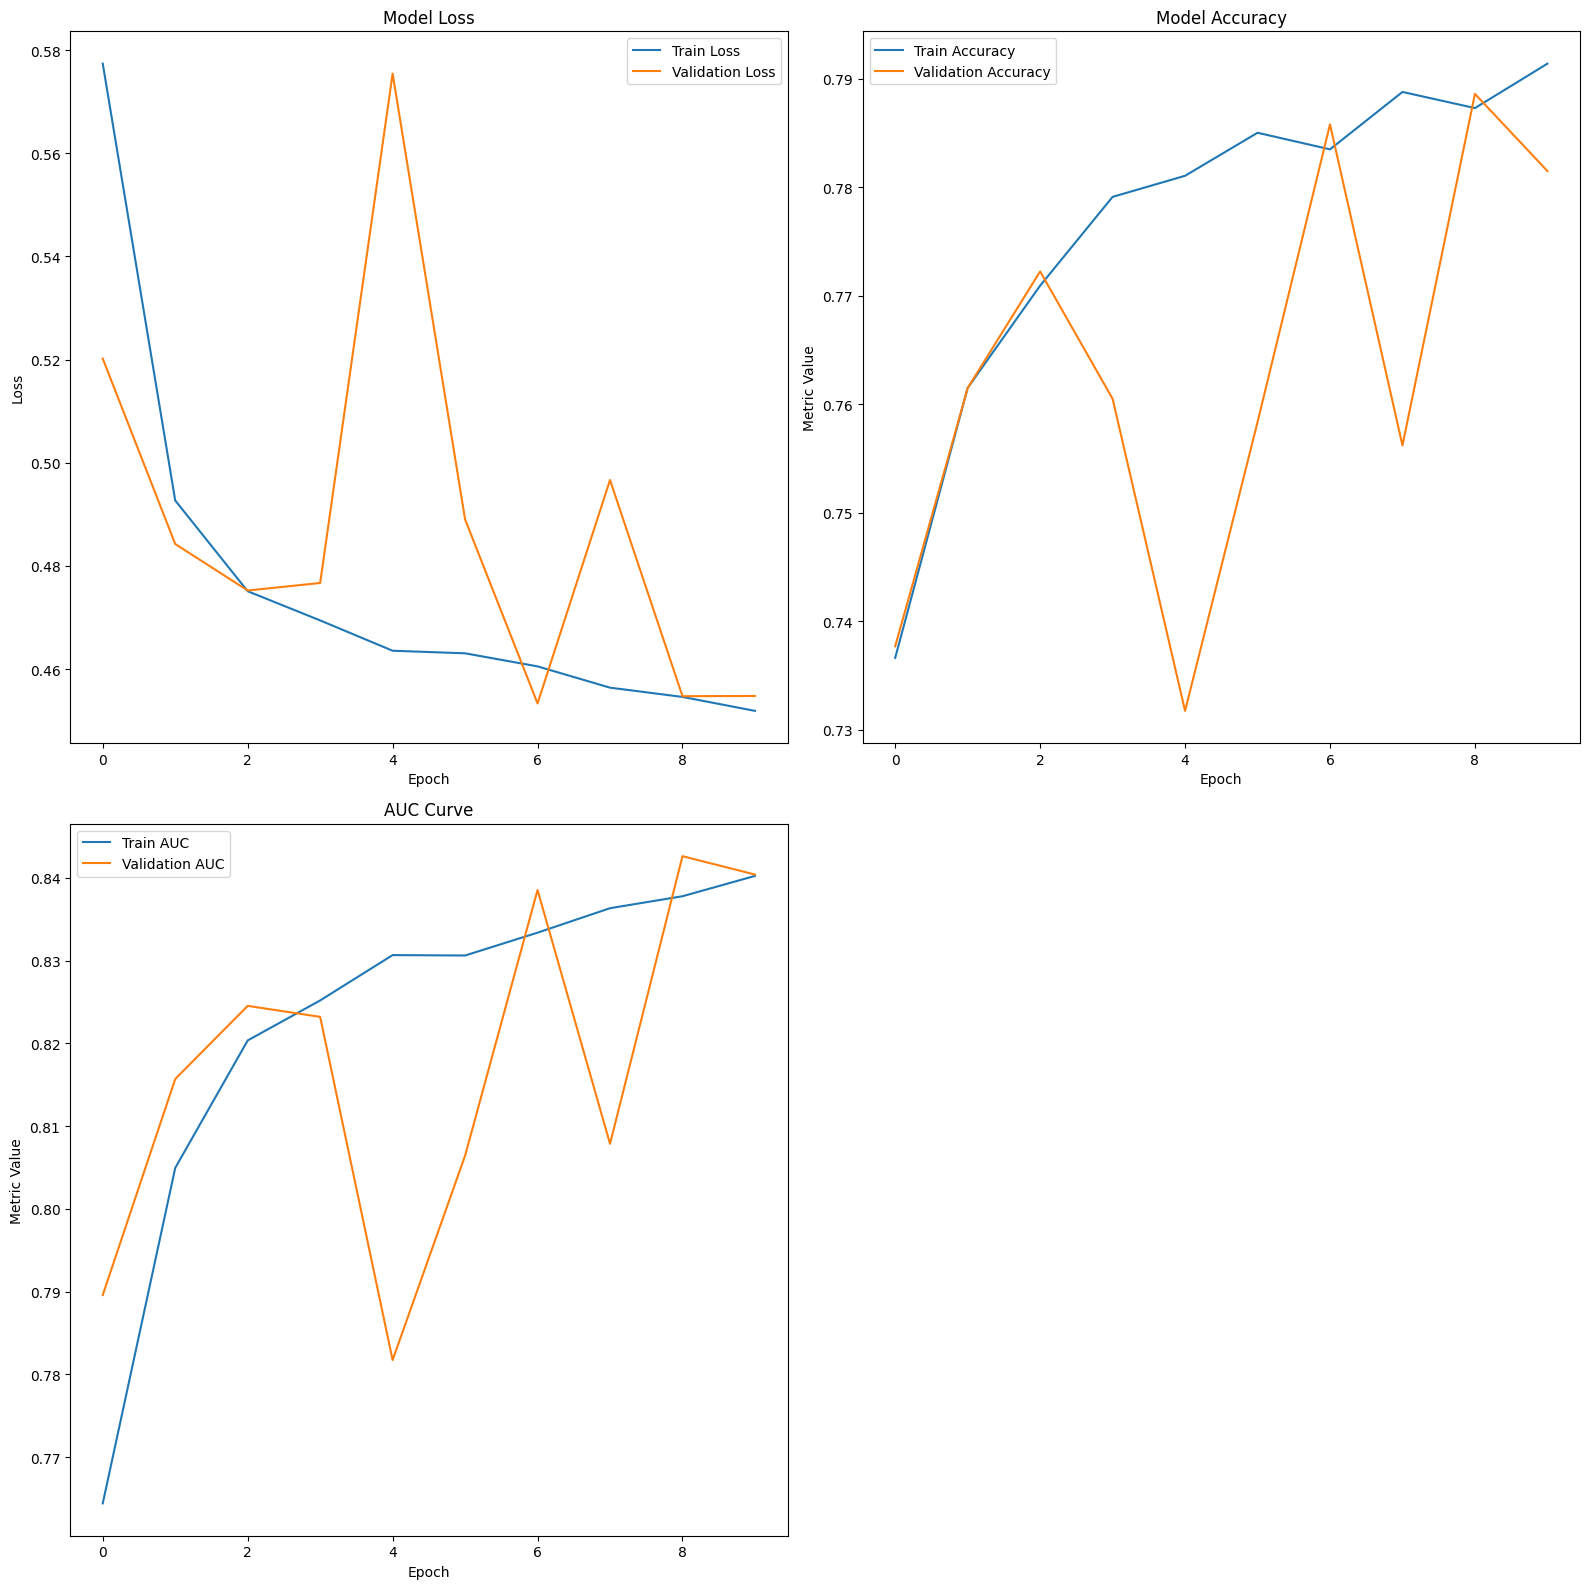

In [35]:
history = cnn_model_rmsprop_history
# Plot training & validation loss values
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(223)
plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.title('AUC Curve')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()